# MINST KIBO
#### Inger van Boeijen, 14 october 2020

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn

## Prep

In [2]:
def create_plots(plot_arr, labels, rows, cols):
    plot_arr = np.array(plot_arr)
    fig = plt.figure(figsize=(20, 12))
    i = 0
    # itterate over the rows and columns
    for row in range(rows):
        for col in range(cols):
            # add each individual image
            ax = fig.add_subplot(rows, cols, i+1)
            ax.imshow(plot_arr[i])
            plt.axis('off')
            ax.set_title(labels[i])
            i += 1
    return fig

### Data

In [3]:
# get the data
mnist = tf.keras.datasets.mnist
# split in train test
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
train, test = mnist.load_data()

In [5]:
ds_train_size = len(train[0])
ds_test_size = len(test[0])
ds_train_size, ds_test_size

(60000, 10000)

### Visualize

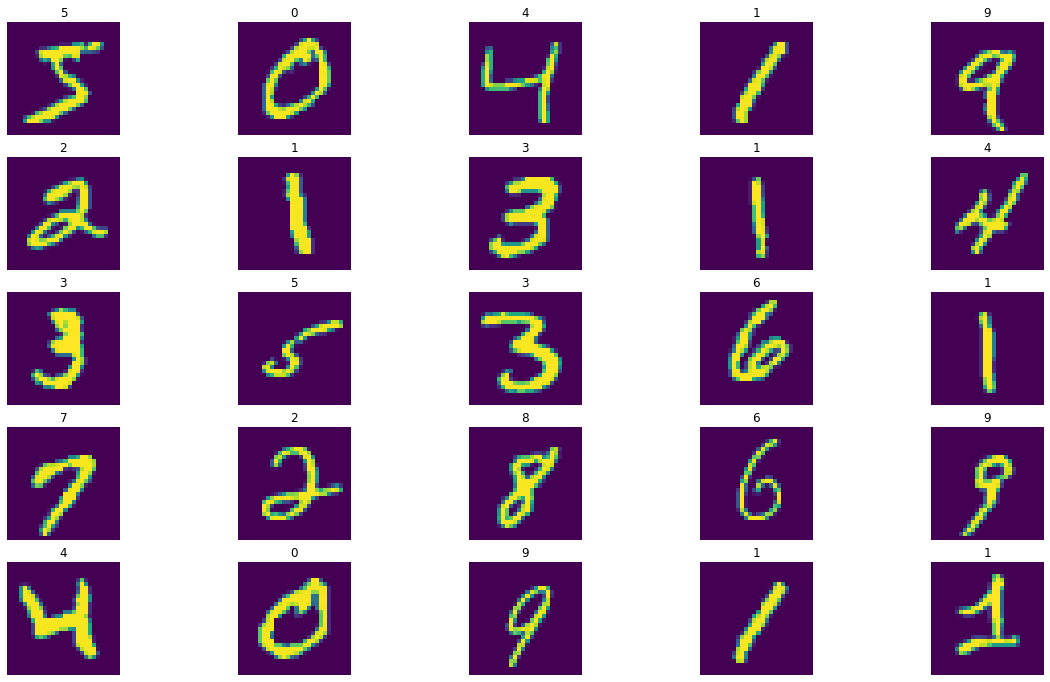

In [6]:
fig = create_plots(x_train[:25], y_train[:25], 5, 5)

# ANN

Sources: https://www.tensorflow.org/datasets/keras_example

We use tensorflow to create a training and eval pipeline. We then create the model, and compile and fit it. Two methods are used to minimize overfitting, the use of dropout layers, and the use of an early stop callback function. 

In [7]:
no_labels = 10
def prep(image, label):
    """Normalize images and one-hot encode labels"""
    # normalize images, cast to float32 and reshape to three dimensions
    image = tf.cast(image, tf.float32) / 255.
    image = tf.reshape(image, (28, 28, 1))
    return image, label

In [8]:
# training pipeline
# create dataset
ds_train = tf.data.Dataset.from_tensor_slices(train)
# apply transformations, see https://www.tensorflow.org/guide/data_performance
ds_train = ds_train.map(
    prep, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# shuffle and slice
ds_train = ds_train.shuffle(ds_train_size).batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
# create testing dataset and apply transormations
ds_test = tf.data.Dataset.from_tensor_slices(test)
ds_test = ds_test.map(
    prep, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
# model is 
# In -> [Conv, BatchNorm, MaxPool, Dropout] * 3 -> 
# Flatten -> Dense -> Dropout -> Dense -> Out

# Put BatchNorm after relu as it showed better results. This isn't how
# it was introduced in the core paper, however there has been quite some 
# evidence showing that after makes more sense. 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', activation='relu', input_shape = (28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), padding = 'same', activation='relu', input_shape = (28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'softmax')  
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [11]:
# early stopping allows for stopping after a certain epoch if the 
# val loss is not improving. This helps against overfitting
earlystopping = EarlyStopping(monitor ="val_loss", min_delta=0,
                              mode = 'auto', patience = 3,
                              restore_best_weights = True)

# state the loss function, optimizer and the evaluation metrics. 
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# fit the model, with 6 epochs to save time. We can do more. In this case early stopping
# would most likely be activated at some point
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
    callbacks=[earlystopping]
)

Train for 469 steps, validate for 79 steps
Epoch 1/6
469/469 [==============================] - 64s 137ms/step - loss: 0.3728 - accuracy: 0.8844 - val_loss: 0.1327 - val_accuracy: 0.9591
Epoch 2/6
469/469 [==============================] - 59s 126ms/step - loss: 0.1098 - accuracy: 0.9678 - val_loss: 0.0371 - val_accuracy: 0.9881
Epoch 3/6
469/469 [==============================] - 59s 126ms/step - loss: 0.0802 - accuracy: 0.9757 - val_loss: 0.0287 - val_accuracy: 0.9907
Epoch 4/6
469/469 [==============================] - 59s 125ms/step - loss: 0.0696 - accuracy: 0.9793 - val_loss: 0.0298 - val_accuracy: 0.9906
Epoch 5/6
469/469 [==============================] - 59s 125ms/step - loss: 0.0616 - accuracy: 0.9819 - val_loss: 0.0226 - val_accuracy: 0.9930
Epoch 6/6
469/469 [==============================] - 60s 127ms/step - loss: 0.0542 - accuracy: 0.9841 - val_loss: 0.0224 - val_accuracy: 0.9925


# Validation insights

In [12]:
def val_extensive(model, X_test, y_test):
    # Testing report
    y_test_pred = np.argmax(model.predict(ds_test), axis=1)

    # classification report
    print("Create testing classification report ...")
    print(classification_report(y_test, y_test_pred))

    # Plot heatmap
    c_matrix = confusion_matrix(y_test, y_test_pred)
    labels = unique_labels(y_test, y_test_pred)
    names = sorted(list(set(labels)))
    df_cm = pd.DataFrame(c_matrix, index=names, columns=names)
    plot_heatmap(df_cm)
    
def plot_heatmap(df_cm, vmax=None, title=""):
    # Plot confusion matrix as a heat-map
    plt.figure(figsize=(15, 15))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, cmap="YlGnBu", vmax=vmax, xticklabels=1)
    plt.xlabel("Predicted", fontsize=20)
    plt.ylabel("Actual", fontsize=20)
    plt.show()
    

Create testing classification report ...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



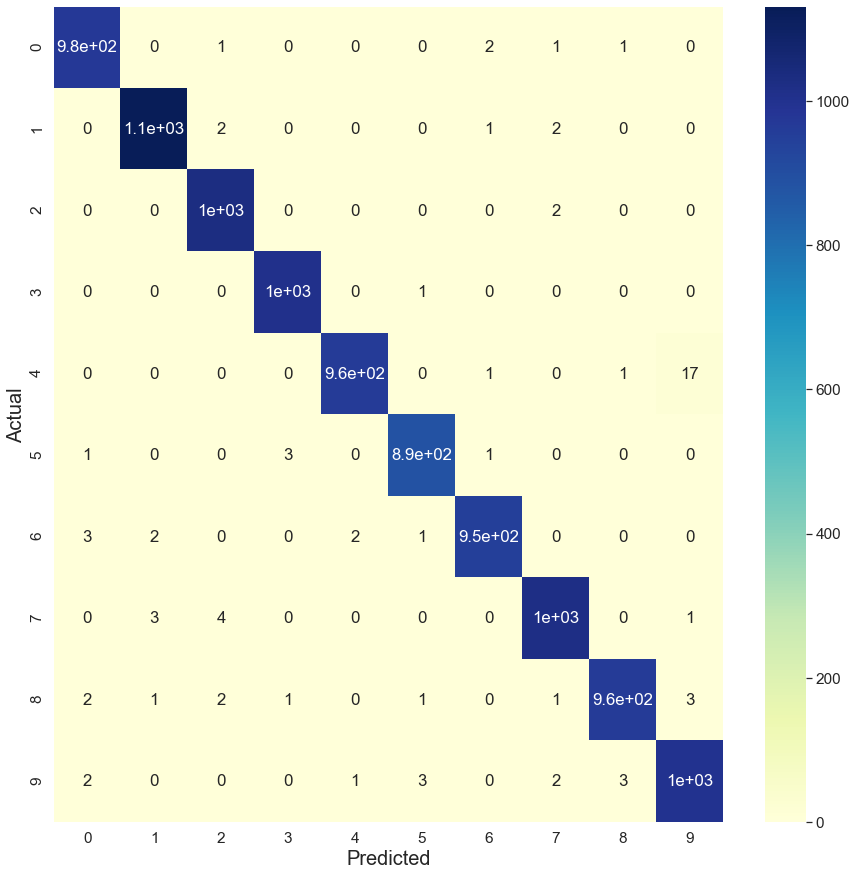

In [13]:
val_extensive(model, x_test, y_test)

In [15]:
 !jupyter nbconvert --to html mnist.ipynb

[NbConvertApp] Converting notebook mnist.ipynb to html
[NbConvertApp] Writing 698500 bytes to mnist.html
